# Assessment 3

In [1]:
import glob
import os
import numpy as np
import pandas as pd
import math

import pickle
import gensim
from gensim.utils import simple_preprocess
from gensim.parsing.preprocessing import STOPWORDS
from gensim import corpora, models
from nltk.stem import WordNetLemmatizer, SnowballStemmer
from nltk.stem.porter import *

import random
random.seed(2021)

import nltk
import re
from pprint import pprint
import matplotlib.pyplot as plt
from IPython.display import display, clear_output

from timeit import Timer
from functools import partial

from sklearn.manifold import TSNE
from bokeh.io import output_notebook
from bokeh.plotting import figure, show
from bokeh.models import HoverTool, CustomJS, ColumnDataSource, Slider
from bokeh.layouts import column
from bokeh.palettes import all_palettes
output_notebook()

Loading BokehJS ...

First we need to import the data. References 1 & 2 introduced me to glob which then allows us to import all the text documents in one smooth process. We do this below.

In [2]:
from pathlib import Path

corpus = []

for path in Path(r'C:\Users\corri\OneDrive\Documents\GitHub\DST-Assessment-3\Data\All enron unzip').rglob('*.txt'):
        with open(path, errors='ignore') as f_input:
            corpus.append(f_input.read())

In [3]:
df = pd.DataFrame(corpus)

In [4]:
df.head()

,0
0,Legitimate\n----------\n- Owner: farmer-d\n- T...
1,Subject: christmas tree farm pictures\n
2,"Subject: vastar resources , inc .\ngary , prod..."
3,Subject: calpine daily gas nomination\n- calpi...
4,Subject: re : issue\nfyi - see note below - al...


In [5]:
print(len(df))

27721


While importing the files, we've also imported the summary sheets along with them. These need to be removed as they wont contribute to our overall corpus and we do this below along with reindexing the data set (we could just remove them from the data but this is easy).

In [6]:
df = df.drop([0,5173,11031,16544,21720]) # removing unnecessary entries
nlist = np.arange(0,27717,1) # reindexing
df = df.reindex(nlist)
df = df.drop(0)
df.columns = ['E-mails']

In [7]:
df.head()

,E-mails
1,Subject: christmas tree farm pictures\n
2,"Subject: vastar resources , inc .\ngary , prod..."
3,Subject: calpine daily gas nomination\n- calpi...
4,Subject: re : issue\nfyi - see note below - al...
5,Subject: meter 7268 nov allocation\nfyi .\n- -...


We're going to assign a binary variable for spam vs normal data to our data set to allow us to perform performance analysis later on. This is done simply since we know where the splits will be for spam/normal data will be in our data frame and we do this below by first creating a list of the positions where spam emails are found and then assigning the binary values to our data frame.

In [8]:
z1 = np.arange(3673,5173)
z2 = np.arange(9534,11031)
z3 = np.arange(15043,16544)
z4 = np.arange(18043,21719)
z5 = np.arange(23220,27716)
ze = np.concatenate((z1,z2,z3,z4,z5))

In [9]:
z = np.zeros(27716)
df['spam'] = z
for i in ze:
    df.iloc[i,1] = 1

In [10]:
df.head()

,E-mails,spam
1,Subject: christmas tree farm pictures\n,0.0
2,"Subject: vastar resources , inc .\ngary , prod...",0.0
3,Subject: calpine daily gas nomination\n- calpi...,0.0
4,Subject: re : issue\nfyi - see note below - al...,0.0
5,Subject: meter 7268 nov allocation\nfyi .\n- -...,0.0


### Pre-Processing for LDA Model

In this section we perform pre-processing for our model. This involves techniques such as removing common words, symbols and punctuation using regex. For sake of comparison, we print the first entry to determine the impact the techniques have.

In [11]:
email_sample = df.iloc[1].values[0] # some of the emails are less tasteful than other emails sorry!
print(email_sample)

Subject: vastar resources , inc .
gary , production from the high island larger block a - 1 # 2 commenced on
saturday at 2 : 00 p . m . at about 6 , 500 gross . carlos expects between 9 , 500 and
10 , 000 gross for tomorrow . vastar owns 68 % of the gross production .
george x 3 - 6992
- - - - - - - - - - - - - - - - - - - - - - forwarded by george weissman / hou / ect on 12 / 13 / 99 10 : 16
am - - - - - - - - - - - - - - - - - - - - - - - - - - -
daren j farmer
12 / 10 / 99 10 : 38 am
to : carlos j rodriguez / hou / ect @ ect
cc : george weissman / hou / ect @ ect , melissa graves / hou / ect @ ect
subject : vastar resources , inc .
carlos ,
please call linda and get everything set up .
i ' m going to estimate 4 , 500 coming up tomorrow , with a 2 , 000 increase each
following day based on my conversations with bill fischer at bmar .
d .
- - - - - - - - - - - - - - - - - - - - - - forwarded by daren j farmer / hou / ect on 12 / 10 / 99 10 : 34
am - - - - - - - - - - - - - - - - - - -

Obviously within emails, there are a multitude of words/symbols that need removing as they will contribute nothing to our modelling. We do this using regex.

In [12]:
df['E-mails'] = [re.sub(r'[^\w\s]','',str(x)) for x in df['E-mails']]

We now check this sample email.

In [13]:
email_sample = df.iloc[1].values[0] # some of the emails are less tasteful than other emails sorry!
print(email_sample)

Subject vastar resources  inc 
gary  production from the high island larger block a  1  2 commenced on
saturday at 2  00 p  m  at about 6  500 gross  carlos expects between 9  500 and
10  000 gross for tomorrow  vastar owns 68  of the gross production 
george x 3  6992
                      forwarded by george weissman  hou  ect on 12  13  99 10  16
am                           
daren j farmer
12  10  99 10  38 am
to  carlos j rodriguez  hou  ect  ect
cc  george weissman  hou  ect  ect  melissa graves  hou  ect  ect
subject  vastar resources  inc 
carlos 
please call linda and get everything set up 
i  m going to estimate 4  500 coming up tomorrow  with a 2  000 increase each
following day based on my conversations with bill fischer at bmar 
d 
                      forwarded by daren j farmer  hou  ect on 12  10  99 10  34
am                           
enron north america corp 
from  george weissman 12  10  99 10  00 am
to  daren j farmer  hou  ect  ect
cc  gary bryan  hou  ect  ect  

### Creating a Dictionary and a Corpus

We use stop words from nltk to remove the majority of the stop words in the data. Some of the words we need to remove are case specific and therefore aren't removed by the stop word processing, such as 'Subject:' which appears in every email and therefore provides no insight for topic modelling.

In [14]:
en_stop = nltk.corpus.stopwords.words('english')
en_stop.append('Subject')

In [15]:
import nltk
from nltk.corpus import wordnet as wn

def sentence_to_words(text):
    tokens = nltk.word_tokenize(text)
    return tokens

def get_lemma(word):
   
    lemma = wn.morphy(word) 
    if lemma is None:
        return word
    else:
        return lemma

def prepare_text_for_lda(text):
    tokens = nltk.word_tokenize(text)
    tokens = [token for token in tokens if len(token) > 4] # removes words length less than 4, likely to be unimportant
    tokens = [token for token in tokens if token not in en_stop] # removes stop words
    tokens = [get_lemma(token) for token in tokens] # lemmatize (standardise) words
    return tokens

When running the below code, we identify entries in the code that are classified as NaN. The pre-processor cannot handle these exceptions so we remove them as they are immaterial to the final result anyway.

In [16]:
place = []

for j in range(1,len(df)):
    try:
        a = df.iloc[j,0]
        sentence_to_words(a)
    except Exception:
        place.append(j)

for j in place:
    df.iloc[j,0] = ""

We first need to tokenize our text to allow us to perform subsequent actions on it. We do this here with the tokenize function above.

In [17]:
words = df['E-mails'].map(sentence_to_words)

We're going to build a bigram model found in link [10]. 

In [18]:
words

1               [Subject, christmas, tree, farm, pictures]
2        [Subject, vastar, resources, inc, gary, produc...
3        [Subject, calpine, daily, gas, nomination, cal...
4        [Subject, re, issue, fyi, see, note, below, al...
5        [Subject, meter, 7268, nov, allocation, fyi, f...
                               ...                        
27712    [Subject, make, big, bucks, in, the, medical, ...
27713    [Subject, proposal, dear, sir, first, i, must,...
27714    [Subject, cure, premature, ejaculation, hello,...
27715    [Subject, need, your, vics, brand, name, meds,...
27716    [Subject, iso, 8859, 1, q, good, _, news, _, c...
Name: E-mails, Length: 27716, dtype: object

In [19]:
bigram = gensim.models.Phrases(words, min_count=10, threshold=100) 
trigram = gensim.models.Phrases(bigram[words], threshold=100)  

bigram_mod = gensim.models.phrases.Phraser(bigram)
trigram_mod = gensim.models.phrases.Phraser(trigram)

We want to check that this has worked correctly:

In [20]:
print(trigram_mod[bigram_mod[words[2]]])

['Subject', 'vastar', 'resources', 'inc', 'gary', 'production', 'from', 'the', 'high', 'island', 'larger', 'block', 'a', '1', '2', 'commenced', 'on', 'saturday', 'at', '2', '00', 'p', 'm', 'at', 'about', '6', '500', 'gross', 'carlos', 'expects', 'between', '9', '500', 'and', '10', '000', 'gross', 'for', 'tomorrow', 'vastar', 'owns', '68', 'of', 'the', 'gross', 'production', 'george', 'x', '3', '6992_forwarded', 'by', 'george_weissman', 'hou', 'ect', 'on', '12', '13', '99', '10', '16', 'am', 'daren_j_farmer', '12', '10', '99', '10', '38', 'am', 'to', 'carlos_j_rodriguez', 'hou', 'ect', 'ect', 'cc', 'george_weissman', 'hou', 'ect', 'ect', 'melissa_graves', 'hou', 'ect', 'ect', 'subject', 'vastar', 'resources', 'inc', 'carlos', 'please', 'call', 'linda', 'and', 'get', 'everything', 'set', 'up', 'i', 'm', 'going', 'to', 'estimate', '4', '500', 'coming', 'up', 'tomorrow', 'with', 'a', '2', '000', 'increase', 'each', 'following', 'day', 'based', 'on', 'my', 'conversations', 'with', 'bill', '

From this, we can see that it has worked correctly as many words have been combined into bigrams/trigrams e.g. '24 hours' and 'via_email'. Adjustment of the min_count and threshold variables allows us to control which words are turned into bigrams/trigrams and only identify those that actually should be together. As I'm not 100% sure how to empirically figure these out I'm working 'by eye' and finding combinations that produce the 'most sensible' results. The current settings seen to combine 'correct' words such as those given above and names.

In [21]:
def make_bigrams(texts):
    return [bigram_mod[doc] for doc in texts]

def make_trigrams(texts):
    return [trigram_mod[bigram_mod[doc]] for doc in texts]

We now process our text using the above functions and create a bag of words.

In [22]:
#df['E-mails'] = df['E-mails'].map(make_bigrams) # currently not compatible with this, going to look into it

In [23]:
print('original document: ')
words = []
for word in email_sample.split(' '):
    words.append(word)
print(words)

print('\n\n method removing stop words: ')
print(prepare_text_for_lda(email_sample))

original document: 
['Subject', 'vastar', 'resources', '', 'inc', '\ngary', '', 'production', 'from', 'the', 'high', 'island', 'larger', 'block', 'a', '', '1', '', '2', 'commenced', 'on\nsaturday', 'at', '2', '', '00', 'p', '', 'm', '', 'at', 'about', '6', '', '500', 'gross', '', 'carlos', 'expects', 'between', '9', '', '500', 'and\n10', '', '000', 'gross', 'for', 'tomorrow', '', 'vastar', 'owns', '68', '', 'of', 'the', 'gross', 'production', '\ngeorge', 'x', '3', '', '6992\n', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', 'forwarded', 'by', 'george', 'weissman', '', 'hou', '', 'ect', 'on', '12', '', '13', '', '99', '10', '', '16\nam', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '\ndaren', 'j', 'farmer\n12', '', '10', '', '99', '10', '', '38', 'am\nto', '', 'carlos', 'j', 'rodriguez', '', 'hou', '', 'ect', '', 'ect\ncc', '', 'george', 'weissman', '', 'hou', '', 'ect', '', 'ect', '', 'melis

In [24]:
processed_text = df['E-mails'].map(prepare_text_for_lda) 
processed_text.head()

1                                 [christmas, picture]
2    [vastar, resource, production, island, larger,...
3    [calpine, daily, nomination, calpine, daily, n...
4    [issue, already, stella, forward, stella, morr...
5    [meter, allocation, forward, lauri, allen, kim...
Name: E-mails, dtype: object

In [25]:
dictionary = gensim.corpora.Dictionary(processed_text)

count = 0
for k,v  in dictionary.iteritems():
    print(k, v)
    count += 1
    if count > 10:
        break

0 christmas
1 picture
2 advise
3 america
4 appear
5 attach
6 base
7 block
8 bryan
9 carlos
10 coming


In [26]:
bow_corpus = [dictionary.doc2bow(doc) for doc in processed_text]

### Bigram/Trigram

In this section we create our bigram's and trigram's from the text using the functions already learned above.

In [27]:
def make_bigrams(texts):
    return [bigram_mod[doc] for doc in texts]

def make_trigrams(texts):
    return [trigram_mod[bigram_mod[doc]] for doc in texts]

In [28]:
words_bigrams = make_bigrams(processed_text)

### LDA Model

We finally create our LDA Model. We use a chunksize of 2772 with 10 passes of the data which allows us to perform a sort of 10-fold CV (not completely but similar), since chunksize defines the number of documents to be used in each training chunk and passes gives the number of training passes to complete. We do this for 2 topics initially to understand how well the model performs at differentiating spam from normal mail.

In [29]:
lda_model = gensim.models.LdaMulticore(bow_corpus, num_topics = 2, id2word=dictionary, chunksize = 2772, passes=10, workers = 8)

In [30]:
import pyLDAvis.gensim
pyLDAvis.enable_notebook()

In [31]:
lda_display = pyLDAvis.gensim.prepare(lda_model, bow_corpus, dictionary, mds='mmds')

C:\Users\corri\anaconda3\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [32]:
pyLDAvis.display(lda_display, template_type='notebook')

C:\Users\corri\anaconda3\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


### Classification

Here we look at classification using our LDA model and we want to see how well the model identifies spam vs non-spam emails. We need to generate a classification output from the Bag of Words Corpus for each document. We do this by using only 2 topics and creating a list of the assignment of a document to a topic. In the case where the LDA model produces probablities for both topics, we take the largest one to be the topic assignment.

In [33]:
y_pred = []
y_actual = list(df['spam'])

for i in range(0,len(df)):
    for index, score in sorted(lda_model[bow_corpus[i]], key=lambda tup: -1*tup[1]):
        if score >= 0.5 and index == 0:
            y_pred.append(0)
            break
        elif score > 0.5 and index == 1:
            y_pred.append(1)
            break

C:\Users\corri\anaconda3\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


As a check to ensure the above code has worked and will be compatible with our confusion matrix, we check the length of both the lists.

In [34]:
print(len(y_actual), len(y_pred))

27716 27716


C:\Users\corri\anaconda3\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


Next we define our confusion matrix and classification report. We use sklearn metrics to generate this, in a similar way to project 1 and evaluate.

In [35]:
from sklearn.metrics import confusion_matrix, classification_report

def classification_eval(y_true,y_pred):
    
    print("Confusion Matrix")
    C = confusion_matrix(y_true,y_pred)
    
    print('Classification report')
    print(classification_report(y_true, y_pred, target_names = ['Normal', 'Spam'], digits=3))

C:\Users\corri\anaconda3\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [36]:
classification_eval(y_actual,y_pred)

Confusion Matrix
Classification report
              precision    recall  f1-score   support

      Normal      0.844     0.859     0.851     15046
        Spam      0.829     0.811     0.820     12670

    accuracy                          0.837     27716
   macro avg      0.836     0.835     0.835     27716
weighted avg      0.837     0.837     0.837     27716



C:\Users\corri\anaconda3\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


The results here are interesting. We choose the spam/normal assignment based on the 'look' or understanding of the topics and the keywords contained within them. This leads to to the above result which is quite strong. It is noted in the LDA block that it shouldn't be used for classification and should be a keyword generator so this may not provide a good measure of the actual accuracy of the LDA model. The later models we consider should improve upon this result when we get the 'correct' amount of topics.

In [37]:
pickle.dump(y_pred, open('../Data/Matt_pred.p','wb'))
pickle.dump(y_actual, open('../Data/Actual.p','wb'))

C:\Users\corri\anaconda3\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


### Perplexity and Coherence

In this section we review the perplexity and coherence of the model above. This also helps us define coherence functions which will be used later to evaluate the 'correct' number of topics, k.

In [38]:
from gensim.models.coherencemodel import CoherenceModel
def getCoherence(m,c,d):
    coherence_model_lda = CoherenceModel(model=m,corpus=c, dictionary=d, coherence='u_mass')
    coherence_lda = coherence_model_lda.get_coherence()
    return(coherence_lda)

C:\Users\corri\anaconda3\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [39]:
from gensim.models.coherencemodel import CoherenceModel
def getCoherence2(m,t,d):
    coherence_model_lda2 = CoherenceModel(model=m,texts = t, dictionary=d, coherence='c_v')
    coherence_lda2 = coherence_model_lda2.get_coherence()
    return(coherence_lda2)

C:\Users\corri\anaconda3\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [40]:
print("lda_model perplexity: {}".format(lda_model.log_perplexity(bow_corpus)))
print("lda_model coherence using u_mass: {}".format(getCoherence(lda_model,bow_corpus,dictionary)))
print("lda_model coherence using c_v: {}".format(getCoherence2(lda_model,processed_text, dictionary)))

C:\Users\corri\anaconda3\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


lda_model perplexity: -8.41380354887196
lda_model coherence using u_mass: -1.6839825121503265
lda_model coherence using c_v: 0.3787632820858968


### Choosing K (Number of Topics)

Now that we've reviewed the accuracy when using just two topics, we want to understand how many topics there actually are within our emails. We'll use code from [10] with amendments to test the coherence of a range of topic numbers and find the best k. After this, we'll look at the words within these topics and see if we can discern a label for each topic. We're going to use u_mass coherence in the first function and c_v coherence in the second.

In [41]:
def compute_coherence_values(dictionary, corpus, limit, start, step):
    
    coherence_values = []
    model_list = []
    for num_topics in range(start, limit, step):
        
        clear_output(wait=True) # outputting num_topics
        display('Currently finding u_mass coherence with topic: '+str(num_topics)+' of '+str(limit-2)+'.')
        
        model = gensim.models.LdaMulticore(bow_corpus, num_topics = num_topics, id2word=dictionary, chunksize = 2772, passes=10, workers = 8)
        model_list.append(model)
        coherencescore = getCoherence(model,bow_corpus,dictionary)
        coherence_values.append(coherencescore)

    return model_list, coherence_values

C:\Users\corri\anaconda3\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [42]:
def compute_coherence_values2(dictionary, corpus, text, limit, start, step):
    
    coherence_values2 = []
    model_list = []
    for num_topics in range(start, limit, step):
        
        clear_output(wait=True) # outputting num_topics
        display('Currently finding c_v coherence with topic: '+str(num_topics)+' of '+str(limit-2)+'.')
        
        model = gensim.models.LdaMulticore(bow_corpus, num_topics = num_topics, id2word=dictionary, chunksize = 2772, passes=10, workers = 8)
        model_list.append(model)
        coherencescore = getCoherence2(model,processed_text,dictionary)
        coherence_values2.append(coherencescore)

    return model_list, coherence_values2

C:\Users\corri\anaconda3\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [43]:
def compute_perplexity_values(corpus, limit, start, step):
        
    perplexity_values = []
    model_list = []
    for num_topics in range(start, limit, step):
        
        clear_output(wait=True) # outputting num_topics
        display('Currently finding perplexity with topic: '+str(num_topics)+' of '+str(limit-2)+'.')
        
        model = gensim.models.LdaMulticore(bow_corpus, num_topics = num_topics, id2word=dictionary, chunksize = 2772, passes=10, workers = 8)
        model_list.append(model)
        perplexityscore = lda_model.log_perplexity(bow_corpus)
        perplexity_values.append(perplexityscore)
        
    return model_list, perplexity_values

C:\Users\corri\anaconda3\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


For sake of sanity, I'll output the results from the finding the best k tests here since they are insanely time consuming running and will be better to import using pickle. 

Due to the size of the model_list file (over 300mb), we don't save these since the only use for them is to pull a model from and subsequently use. We instead identify the best model and use it, without saving the rest. If you want to reproduce them, the code can be run with the below commented code uncommented and it will produce the model list

In [44]:
try:
    print('Reading u_mass coherence values...')
    coherence_values=pickle.load(open('../Data/Matt_u_mass_values.p','rb'))
    #model_list = pickle.load(open('../Data/Matt_u_mass_models.p','rb')) # uncomment to produce all models
except FileNotFoundError:
    print('File not found.')
    print('Calculating u_mass coherence values.')
    model_list, coherence_values = compute_coherence_values(dictionary=dictionary, corpus=bow_corpus, start=2, limit=40, step=2)
    
    pickle.dump(coherence_values, open('../Data/Matt_u_mass_values.p','wb'))
    #pickle.dump(model_list, open('../Data/Matt_u_mass_models.p','wb'))


Reading u_mass coherence values...


C:\Users\corri\anaconda3\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [45]:
try:
    print('Reading c_v coherence values...')
    coherence_values2=pickle.load(open('../Data/Matt_c_v_values.p','rb'))
    #model_list2 = pickle.load(open('../Data/Matt_c_v_models.p','rb')) # uncomment to produce all models
except FileNotFoundError:
    print('File not found.')
    print('Calculating c_v coherence values.')
    model_list2, coherence_values2 = compute_coherence_values2(dictionary=dictionary, corpus=bow_corpus, text = processed_text, start=2, limit=40, step=2)
    
    pickle.dump(coherence_values2, open('../Data/Matt_c_v_values.p','wb'))
    #pickle.dump(model_list2, open('../Data/Matt_c_v_models.p','wb'))
    #pickle.dump(model_list2[3], open('../Data/Matt_opt_model.p','wb'))


Reading c_v coherence values...


C:\Users\corri\anaconda3\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [46]:
try:
    print('Reading perplexity values...')
    perplexity_values=pickle.load(open('../Data/Matt_perp_values.p','rb'))
    #model_list3 = pickle.load(open('../Data/Matt_perp_models.p','rb')) # uncomment to produce all models
except FileNotFoundError:
    print('File not found.')
    print('Calculating perplexity values.')
    model_list3, perplexity_values = compute_perplexity_values(corpus = bow_corpus, start=2, limit=40, step=2)
    
    pickle.dump(perplexity_values, open('../Data/Matt_perp_values.p','wb'))
    #pickle.dump(model_list3, open('../Data/Matt_perp_models.p','wb'))
    

Reading perplexity values...


C:\Users\corri\anaconda3\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


C:\Users\corri\anaconda3\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


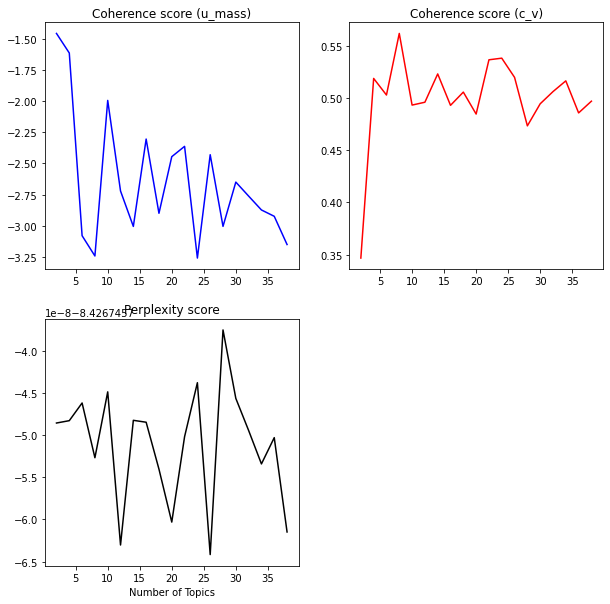

In [47]:
limit=40; start=2; step=2;
x = range(start, limit, step)

fig = plt.figure(figsize= (10,10))
ax1 = fig.add_subplot(221)
ax2 = fig.add_subplot(222)
ax3 = fig.add_subplot(223)

ax1.plot(x, coherence_values, 'b')
ax2.plot(x, coherence_values2, 'r')
ax3.plot(x, perplexity_values, 'k')

plt.xlabel("Number of Topics")

ax1.title.set_text("Coherence score (u_mass)")
ax2.title.set_text("Coherence score (c_v)")
ax3.title.set_text("Perplexity score")

plt.show()

In [48]:
cm1 = coherence_values.index(max(coherence_values))
cm2 = coherence_values2.index(max(coherence_values2))
pm = perplexity_values.index(min(perplexity_values))

print('The number of topics that maximises u_mass coherence is: '+str(2*cm1+2)+' with a u_mass coherence of: '+str(max(coherence_values)))
print('The number of topics that maximises c_v coherence is: '+str(2*cm2+2)+' with a c_v coherence of: '+str(max(coherence_values2)))
print('The number of topics that maximises perplexity is: '+str(2*pm+2)+ ' with a perplexity of: '+str(min(perplexity_values)))

The number of topics that maximises u_mass coherence is: 2 with a u_mass coherence of: -1.456460695864691
The number of topics that maximises c_v coherence is: 8 with a c_v coherence of: 0.5619032894646473
The number of topics that maximises perplexity is: 26 with a perplexity of: -8.426745764168075


C:\Users\corri\anaconda3\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


Here we see that the maximum is in different positions. When using u_mass coherence, we get a maximum coherence at **k = 2**, when using c_v coherence we get a maximum coherence at **k = 8** and when using perplexity we get a maximum coherence at **k=12**. From the paper given in reference [15], c_v is the best option for evaluating topic models (u_mass is faster but not as accurate) and thus we will use the model with k = 8 topics.

###### Aside - Timing

*As an aside, after the block 8 work, I wanted to time this last function to see how slow/fast it was when changing the number of topics. We normally look at how the function changes with the size of the input i.e. n but I wanted to consider this variable and see if it had an impact. We use the timing function defined in that workshop.*

In [49]:
def time_fun(fun,l,rep=5):
    t=Timer(partial(fun,l))
    return([l,t.timeit(rep)/rep])

C:\Users\corri\anaconda3\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


We also define a new function for our calculation that only takes t as an input.

In [50]:
def compute_coherence_values_t(t):
    
    coherence_values = []
    model_list = []
    for num_topics in range(t, t+2, 2):
        
        clear_output(wait=True) # outputting num_topics
        display('Currently finding u_mass coherence with number of topics: '+str(num_topics)+'.')
        
        model = gensim.models.LdaMulticore(bow_corpus, num_topics = t, id2word=dictionary, chunksize = 2772, passes=10, workers = 2)
        model_list.append(model)
        coherencescore = getCoherence(model,bow_corpus,dictionary)
        coherence_values.append(coherencescore)

    return model_list, coherence_values

C:\Users\corri\anaconda3\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [51]:
ti = np.arange(2,20)

C:\Users\corri\anaconda3\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


Similarly, the code here is arduous and long and therefore we will save it to a pickle document.

In [52]:
try:
    print("Reading corpus from pickle...")
    times=pickle.load(open('../data/Matt_times.p', 'rb'))
except FileNotFoundError:
    print('File not found.')
    print('Creating times.')
    times=np.array(
        [time_fun(compute_coherence_values_t, t) for t in ti])
    pickle.dump(times, open('../Data/Matt_times.p','wb'))

Reading corpus from pickle...


C:\Users\corri\anaconda3\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


C:\Users\corri\anaconda3\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


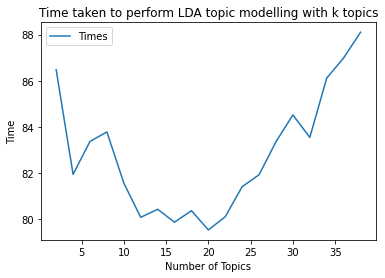

In [53]:
plt.plot(times[:,0],
         times[:,1])
plt.legend(['Times'])
plt.xlabel('Number of Topics')
plt.ylabel('Time')
plt.title('Time taken to perform LDA topic modelling with k topics')
plt.show()

This is an unexpected output, we expect some form of upward trend as the number of topics we model increases. Despite seeing a large spike towards the end, there is an initial decrease as the number of topics increases up to 20. This time discrepency is small though and only varies between roughly 8 minutes.

### Optimal Solution

Below we create our optimal solution (or in this case import it) with 8 topics since this had the best c_v coherence.

In [54]:
optimal_model = pickle.load(open('../Data/Matt_opt_model.p','rb'))
model_topics = optimal_model.show_topics(formatted=False)
pprint(optimal_model.print_topics(num_words=10))

C:\Users\corri\anaconda3\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


[(0,
  '0.013*"market" + 0.011*"power" + 0.010*"price" + 0.009*"business" + '
  '0.008*"would" + 0.008*"energy" + 0.008*"company" + 0.007*"enron" + '
  '0.005*"state" + 0.005*"trading"'),
 (1,
  '0.029*"vince" + 0.023*"enron" + 0.016*"kaminski" + 0.013*"would" + '
  '0.012*"please" + 0.012*"subject" + 0.009*"research" + 0.008*"forward" + '
  '0.007*"thanks" + 0.007*"group"'),
 (2,
  '0.048*"enron" + 0.015*"subject" + 0.013*"please" + 0.009*"louise" + '
  '0.008*"thanks" + 0.008*"message" + 0.007*"original" + 0.007*"forward" + '
  '0.006*"attach" + 0.006*"would"'),
 (3,
  '0.012*"please" + 0.011*"email" + 0.009*"information" + 0.008*"receive" + '
  '0.008*"account" + 0.007*"business" + 0.007*"money" + 0.006*"click" + '
  '0.006*"address" + 0.006*"contact"'),
 (4,
  '0.073*"enron" + 0.030*"company" + 0.015*"dynegy" + 0.012*"share" + '
  '0.011*"stock" + 0.011*"billion" + 0.010*"jones" + 0.009*"energy" + '
  '0.009*"investor" + 0.008*"credit"'),
 (5,
  '0.027*"company" + 0.017*"statement"

In [55]:
print("lda_model perplexity: {}".format(optimal_model.log_perplexity(bow_corpus)))
print("lda_model coherence using u_mass: {}".format(getCoherence(optimal_model,bow_corpus,dictionary)))
print("lda_model coherence using c_v: {}".format(getCoherence2(optimal_model,processed_text, dictionary)))

opt_values = [optimal_model.log_perplexity(bow_corpus),getCoherence(optimal_model,bow_corpus,dictionary),getCoherence2(optimal_model,processed_text, dictionary)]
pickle.dump(opt_values, open('../Data/Matt_opt_values.p','wb'))

C:\Users\corri\anaconda3\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


lda_model perplexity: -8.149249010668818
lda_model coherence using u_mass: -1.8666366370766145
lda_model coherence using c_v: 0.5619032894646473


In [56]:
lda_opt_display = pyLDAvis.gensim.prepare(optimal_model, bow_corpus, dictionary, mds='mmds')

C:\Users\corri\anaconda3\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [57]:
pyLDAvis.display(lda_opt_display, template_type='notebook')

C:\Users\corri\anaconda3\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


We see that there is some overlap in topics which is a downfall of this piece of LDA since we would prefer to see distinct topics but this does a much better job of creating topics and finding commonality between the documents. Topics 7 and 8 are definitely a grouping of spam emails while the others appear to be normal emails but since we know that we have a (somewhat) 1:1 ratio the other topics must also contain spam emails.

The cells below delve deeper into the topics and try to extract meaningful data. We first look at each document and determine the dominant topic, the topic contribution i.e. 'how much' of the topic is in that document and then look at the keywords for that document. After this we take a look at each topic individually and determine what the key words are and what the most influentiatl document is from that topic.

In [58]:
def format_topics_sentences(ldamodel, corpus, texts):
    
    sent_topics_df = pd.DataFrame()

    # Get main topic in each document
    for i, row in enumerate(ldamodel[corpus]):
        row = sorted(row, key=lambda x: (x[1]), reverse=True)
        
        # Get the Dominant topic, Perc Contribution and Keywords for each document
        for j, (topic_num, prop_topic) in enumerate(row):
            if j == 0:  # => dominant topic
                wp = ldamodel.show_topic(topic_num)
                topic_keywords = ", ".join([word for word, prop in wp])
                sent_topics_df = sent_topics_df.append(pd.Series([int(topic_num), round(prop_topic,4), topic_keywords]), ignore_index=True)
            else:
                break
    sent_topics_df.columns = ['Dominant_Topic', 'Perc_Contribution', 'Topic_Keywords']

    # Add original text to the end of the output
    contents = pd.Series(texts)
    sent_topics_df = pd.concat([sent_topics_df, contents], axis=1)
    return(sent_topics_df)

C:\Users\corri\anaconda3\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [59]:
df_topic_sents_keywords = format_topics_sentences(ldamodel=optimal_model, corpus=bow_corpus, texts=processed_text)

df_dominant_topic = df_topic_sents_keywords.reset_index()
df_dominant_topic.columns = ['Document_No', 'Dominant_Topic', 'Topic_Perc_Contrib', 'Keywords', 'Text']

df_dominant_topic.head(10)

C:\Users\corri\anaconda3\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


,Document_No,Dominant_Topic,Topic_Perc_Contrib,Keywords,Text
0,0,7.0,0.7079,"software, adobe, price, professional, windows,...",NaN
1,1,2.0,0.9349,"enron, subject, please, louise, thanks, messag...","[christmas, picture]"
2,2,2.0,0.8750,"enron, subject, please, louise, thanks, messag...","[vastar, resource, production, island, larger,..."
3,3,2.0,0.9835,"enron, subject, please, louise, thanks, messag...","[calpine, daily, nomination, calpine, daily, n..."
4,4,2.0,0.9841,"enron, subject, please, louise, thanks, messag...","[issue, already, stella, forward, stella, morr..."
5,5,2.0,0.9444,"enron, subject, please, louise, thanks, messag...","[meter, allocation, forward, lauri, allen, kim..."
6,6,2.0,0.7545,"enron, subject, please, louise, thanks, messag...","[mcmullen, jackie, since, inlet, river, plant,..."
7,7,2.0,0.9216,"enron, subject, please, louise, thanks, messag...","[meter, george, following, 27049, receipt, pac..."
8,8,2.0,0.9900,"enron, subject, please, louise, thanks, messag...","[number, change, forward, payne, antoine, pier..."
9,9,2.0,0.7995,"enron, subject, please, louise, thanks, messag...","[ranch, fields, difficulty, unify, system, ran..."


In [60]:
# Group top 5 sentences under each topic
sent_topics_sorteddf = pd.DataFrame()

sent_topics_outdf_grpd = df_topic_sents_keywords.groupby('Dominant_Topic')

for i, grp in sent_topics_outdf_grpd:
    sent_topics_sorteddf = pd.concat([sent_topics_sorteddf, 
                                             grp.sort_values(['Perc_Contribution'], ascending=[0]).head(1)], 
                                            axis=0)

# Reset Index    
sent_topics_sorteddf.reset_index(drop=True, inplace=True)

# Format
sent_topics_sorteddf.columns = ['Topic_Num', "Topic_Perc_Contrib", "Keywords", "Text"]

# Show
sent_topics_sorteddf

C:\Users\corri\anaconda3\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


,Topic_Num,Topic_Perc_Contrib,Keywords,Text
0,0.0,0.9994,"market, power, price, business, would, energy,...","[enron, mention, louise, reach, congrats, hous..."
1,1.0,0.9996,"vince, enron, kaminski, would, please, subject...","[pnrecet, meedication, paliourg, succession, l..."
2,2.0,0.9988,"enron, subject, please, louise, thanks, messag...","[production, sitara, deal, need, vance, ticket..."
3,3.0,0.9992,"please, email, information, receive, account, ...","[encomium, title, ashore, need, sofft, bottom,..."
4,4.0,0.9978,"enron, company, dynegy, share, stock, billion,...","[house, take, hello, would, reflnance, thousan..."
5,5.0,0.9990,"company, statement, security, information, wit...","[alhaji, amino, danba, former, financial, cont..."
6,6.0,0.9990,"claim, message, email, please, program, number...","[employment, application, madam, please, atten..."
7,7.0,0.9988,"software, adobe, price, professional, windows,...","[woman, change]"


### Other Visualisation

Finally, we look into a tsne visualisation. This is a visualisation using the TSNE function from scikit.learn and creates an interactive plot of the emails.

In [61]:
hm = np.zeros((len(bow_corpus),8))
for i in range(len(bow_corpus)):
    doc = optimal_model[bow_corpus[i]]
    for j in range(len(doc)):
        top = doc[j][0]
        val = doc[j][1]
        hm[i,top] = val


C:\Users\corri\anaconda3\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [62]:
tsne = TSNE(random_state=2017, perplexity=30, early_exaggeration=120, n_jobs=8)
embedding = tsne.fit_transform(hm)
embedding = pd.DataFrame(embedding, columns=['x','y'])
embedding['hue'] = hm.argmax(axis=1)

C:\Users\corri\anaconda3\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


**The below code is turned into markdown (instead of commenting multiple lines of code). It's the actual visualisation of the TSNE model, which has been 'commented' out since it takes the file from 300Kb to 44Mb. Please run it when it's downloaded, I just couldnt upload the code to github with this.**

source = ColumnDataSource(
        data=dict(
            x = embedding.x,
            y = embedding.y,
            colors = [all_palettes['Set1'][8][i] for i in embedding.hue],
            title = df['E-mails'],
            alpha = [0.9] * embedding.shape[0],
            size = [7] * embedding.shape[0]
        )
    )
hover_tsne = HoverTool(names=["df"], tooltips="""
    <div style="margin: 10">
        <div style="margin: 0 auto; width:300px;">
            <span style="font-size: 12px; font-weight: bold;">Title:</span>
            <span style="font-size: 12px">@title</span>
        </div>
    </div>
    """)
tools_tsne = [hover_tsne, 'pan', 'wheel_zoom', 'reset']
plot_tsne = figure(plot_width=700, plot_height=700, tools=tools_tsne, title='E-mails')
plot_tsne.circle('x', 'y', size='size', fill_color='colors', 
                 alpha='alpha', line_alpha=0, line_width=0.01, source=source, name="df")

layout = column(plot_tsne)
show(layout)

### References

1. [Loading .txt files](https://stackoverflow.com/questions/42407976/loading-multiple-text-files-from-a-folder-into-a-python-list-variable)
2. [Using Glob to retrieve the data](https://stackoverflow.com/questions/2186525/how-to-use-glob-to-find-files-recursively)
3. [WordNet guidance](https://www.nltk.org/howto/wordnet.html)
4. [Lemmatisation](https://www.geeksforgeeks.org/python-lemmatization-with-nltk/)
5. [Stop Words](https://www.geeksforgeeks.org/removing-stop-words-nltk-python/)
6. [Adding Stop Words](https://stackoverflow.com/questions/5511708/adding-words-to-nltk-stoplist)
7. [Classificaiton Report](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.classification_report.html)
8. [Filtering Extereme values from a Dictionary](https://stackoverflow.com/questions/51634656/filtering-tokens-by-frequency-using-filter-extremes-in-gensim)
9. [General LDA - used for index, score function in Classification](https://towardsdatascience.com/topic-modeling-and-latent-dirichlet-allocation-in-python-9bf156893c24)
10. [Topic Modelling in a similar setup](https://www.machinelearningplus.com/nlp/topic-modeling-gensim-python/)
11. [gensim.models.phrases documentation](https://radimrehurek.com/gensim/models/phrases.html)
11. [Using regex on data frame columns](https://stackoverflow.com/questions/53962844/applying-regex-across-entire-column-of-a-dataframe)
12. [Coherence Types](https://radimrehurek.com/gensim/models/coherencemodel.html)
13. [Using Pickle](https://docs.python.org/3/library/pickle.html#data-stream-format)
14. [c_v or u_mass](http://svn.aksw.org/papers/2015/WSDM_Topic_Evaluation/public.pdf)
16. [TSNE visualisation of LDA](https://www.kaggle.com/yohanb/lda-visualized-using-t-sne-and-bokeh/comments)